# PIA - Reinforcement Learning

1. RL Intro
2. Dynamic Programing
3. Tabular Q-Learning
4. **Deep Reinforcement Learning (DQN)**

## 4. Deep Reinforcement Learning (DQN)

Welcome to the final Reinforcement Learning Notebook. In this part you will implement the Deep Q-Learning Algorithm that was used by Mnih et al. to play Atari Video games. The resulting agent is called Deep Q-Network agent (or shorter DQN agent) because it uses a Deep Neural Network to approximate the value function (instead of saving it in a table).

---
### Course of Action

* Please write all executable python code in ```Code```-Cells (```Cell```->```Cell Type```->```Code```) and all Text as [Markdown](http://commonmark.org/help/) in ```Markdown```-Cells
* Describe your thinking and your decisions (where appropriate) in an extra Markdown Cell or via Python comments
* In general: discuss all your results and comment on them (are they good/bad/unexpected, could they be improved, how?, etc.). Furthermore, visualise your data (input and output).
* Write a short general conclusion at the end of the notebook
* Further experiments are encouraged. However, don't forget to comment on your reasoning.
* Use a scientific approach for all experiments (i.e. develop a hypothesis or concrete question, make observations, evaluate results)

### Submission

E-Mail your complete Notebook to [maucher@hdm-stuttgart.de](mailto:maucher@hdm-stuttgart.de) until the start of the next lecture. One Notebook per Group is enough. Edit the teammember table below.

**Important**: Also attach a HTML version of your notebook (```File```->```Download as```->```HTML```) in addition to the ```.ipynb```-File.

| Teammember |                    |
|------------|--------------------|
| 1.         | Christopher Caldwell |
| 2.         | Fabian Müller      |
| 3.         | An Dang         |

## Prerequisites

- **INSTALL**: [OpenAI Gym](https://github.com/openai/gym#installation) - minimal install should be enough.
- The notebook is pretty self contained and includes all relevant theory. However, make sure that you have **read** and *understood* a corresponding lecture at least once! The notebook can only provide a short recap. Being prepared will help you to finish the notebook in time!
- Some good reading resources are:

    1. Johannes Maucher's [lecture on RL](https://maucher.home.hdm-stuttgart.de/MachineLearning/WS1718/V12Reinforcement.pdf) - chapter 4,5 & **6**.
    2. David Silver's course on RL: [Lecture 6](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html): [Youtube](https://www.youtube.com/watch?v=UoPei5o4fps), [Lecture 9](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html): [Youtube](https://www.youtube.com/watch?v=sGuiWX07sKw&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&index=9).
    3. Sutton & Barto: [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) chapter **16.5**, further reading and more details chapters 9,10 & 11 (complete online pdf draft available).
    4. Read the original DQN papers:
        - NIPS 2013 - [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)
        - Nature 2015 - [Human Level Control Through Deep Reinforcement Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning/)

---

## Theory

In the last notebook you have implemented the model-free **Q-Learning** algorithm and solved the *full reinforcement learning problem* by **learning from samples**. In this context, *full* refered to the fact that we dont have acess to the world model and *model-free* to the fact that we have not tried to learn that model. Furthermore, Q-Learning performed **online** updates to the policy, meaning that we have adjusted the policy *online* after every time step. Finally Q-Learning is an **off-policy** algorithm because we followed an e-greedy behavior policy while we have performed updates according to a greedy target policy. Now we will tackle the **curse of dimensionality** by **approximating the value function** instead of saving it explicitly in a table.

### Case Study - Video Games

<img src="./RL_pics/Atari_games.png" alt="DQN" style="width: 1000px;"/>

Before we proceed to the solution, let us quickly revise the actual problem that we are trying to solve. Consider the task of learning to play a video game given only the raw game screen as input. This is similar to how humans would play the game. Since the game screen is typically represented as raw pixels, this leaves us with a really high dimensional input or state space because every change of pixels represents a new and distinct state of the game, even if the change seems completely insignificant to you! Remember, the agent has no real knowledge of the game (or world model). Clearly it is infeasible to store every possible state of pixle combinations in a table. See [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) chapter 16.5 for a comprehensive discussion.   

<img src="./RL_pics/DQN_principle.png" alt="DQN" style="width: 800px;"/>

> The problem that is solved by Deep Reinforcement Learning (in the case of DQN) is how to learn a mapping from a high dimensional input space to action values. This mapping represents the value function and can be used in a policy, e.g. to choose the best action with the highest value.


### Nonlinear Function Approximation with Artificial Neural Networks

First of all, a lookup table can mathematically be seen as a very simple form of a function, i.e. a direct mapping of values (hence the name value function). However, for the reasons explained above, this approach does not scale to high dimensional input spaces. A typical solution to this problem is to replace the *perfect* but intractable lookup table with a more complicated function that *only* **approximates the true value function** but is computationally tractable. In the case of DQN we choose a deep neural network as our function approximator. Formally, this new function is denoted as $\hat{Q}$ and we write

$$\begin{eqnarray} 
\hat{Q}(s,a,\theta) \approx Q_{\pi}(s,a)
\end{eqnarray}$$

where $\theta$ are the parameters of the neural network. In other words, the value function now depends on those parameters and the task of finding and optimal value function turns into the task of finding an optimal set of parameters for the network. Fortunately, we know how to train and optimize a neural network with SGD and backpropagation given an appropriate loss function. **Inside the RL-framework we can use the TD-error as the loss function**. Formally we optimize:  

$$\begin{eqnarray} 
L_i(\theta_{i}) = \Big( \underbrace{r_{t+1} + \gamma \max_a Q(s_{t+1}, a; \theta_i) - Q(s_t, a_t;\theta_i)}_{TD-error} \Big)^2
\end{eqnarray}$$

> Note that in order to obtain any action-values, we now need to perform a forward pass through the network. In practice, this means two forward passes before we can calculate the loss, one pass for the value of $Q(s_t, a_t;\theta_i)$ and another one to calculate the value of $\max_a Q(s_{t+1}, a; \theta_i)$. More details on that later.


### Instabilities and Solutions

So far, so good. By using the TD-error as loss function we can train the network in a supervised learning like setup. Sadly it is not that easy. Remember that in supervised learning we assumed the data to be *independent and identically distributed* (iid-data) in order for SGD to work properly. This assuption does not hold in reinforcement learning where subsequent data is highly correlated and in contrast, depends strongly on the agents last choice of actions. This inherent sequential property, in combination with an off-policy algorithm and a non-linear function appoximator such as a neural network, results in the problem that the learnable network parameters are at risk to oscillate or even diverge catastrophically during training. In theory, there is no convergence guarantee whatsoever. In practice, Mnih et al. found two major ways in which the training process can be stabilized:

- **Experience Replay** - This idea introduces a so called **replay buffer** $\mathcal{D}$ which stores the last $N$ state transitions as experience tuples $(S,A,R,S')$. In other words, the agent saves its recent history to a buffer. This way, experience can be reused and the correlation between samples can be broken by **drawing random minibatches** of experience $U(\mathcal{D})$ from it during the training.
<br><br>

- **Fixed Q-Targets** - The second idea is to keep **a separate set of parameters** $\theta^{−}$ for calculating the **TD target**. This set is basically a copy of $\theta$ that is held fixed for some time $t$ and periodically gets swapped with the current parameter values in order to allow progress. Mnih et al. have shown that updating $\theta$ towards such fixed Q-targets is another effective way to stabilize the training process. In practice, this means that we have basically two separate networks which we will distinguish by their different set of parameters $\theta^{-}$ and $\theta$. We will refer to them respectively as **Target-** and **Q-Network**.

As a result, the **Q-learning update** of DQN at iteration $i$ uses the following loss function: 

$$\begin{eqnarray} 
L_i(\theta_{i}) = \mathbb{E}_{(s,a,r,s') \sim U(\mathcal{D})} \Bigg[ \Bigg( r_{t+1} + \gamma \max_a \underbrace{Q(s_{t+1}, a; \theta^{-}_{i})}_{Target-Network} - \underbrace{Q(s_t, a_t;\theta_i)}_{Q-Network} \Big)^2 \Bigg]
\end{eqnarray}$$

And thats it! We can use this update rule inside the Q-Learning algorithm to train a Deep Q-Network with SGD as we do in supervised learning. The corresponding **Deep Q-Learning algorithm** is given in the next part.

---

## Implementation

As in the previous notebooks we will implement the DQN algorithm step by step. While the original DQN architecture was a CNN trained on Atari games, we will choose a much simpler problem and architecture. This way you can verify and debug your implementation much faster (in minutes vs hours...). However, the algorithm itself is still the same and extending it should be straightforward after completing the notebook. Though, this is left to the *further ideas part* depending on your time and motivation.

The following is an overview of all the parts you need. Use it as a checklist if you get lost. Like with Q-Learning, try first to verify that all the sub-parts are working as expected. If you are confident, integrate them iteratively into the main loop. There is no single best approach how to proceed so feel free to jump back and forth between the cells as you like.

##### Overview

- The OpenAI Gym Environment
- Replay Buffer
- Epsilon Schedule
- Deep Q-Network (and computation graph)
- E-Greedy Policy (action selection)
- Update the Target Network
- Train Method
- Main Loop
<br><br>
- Evaluation of Deep Reinforcement Learning Algorithms



### The Open AI Gym Environment

You will use the OpenAI Gym environment to solve a classic control task known as **Cart Pole Balance**. The great thing about the gym environment is that it offers a common interface to [many different environments](https://gym.openai.com/envs/#classic_control). That way you can easily test your algorithms on different tasks, e.g. switch from an easy one like CartPole to more challenging ones like an Atari game etc. ;)

For now, we will solve the **CartPole-v0** task. 

1. First of all, [go and read](https://github.com/openai/gym/wiki/CartPole-v0) about its most important details such as the *observations, actions, rewards,* it's *max length* etc.
2. Second, get used to the gym interface. Run a random agent for some episodes etc. The most important API calls are:
    - `gym.make('CartPole-v0')` returns a new `game`.
    - The game's `action_space` and `observation_space` variables.
    - `reset()` - returns an initial `observation`.
    - `step()`  - takes an `action` int, returns an `observation, reward, game_over, info` tuple.
    - `render()` - renders the current game state.
    - `close()` - call this after the last episode has ended to clean up.

In [2]:
import gym
import numpy as np

game = gym.make("CartPole-v0")
observation_space = game.observation_space.shape[0]
action_space = game.action_space.n
i=0
while i in range(0,4):
    state = game.reset()
   
    state = np.reshape(state, [1, observation_space])
    print(state)
    x = 0
    while x in range(0,200):
        state_next, reward, terminal, info  = game.step(np.random.randint(0,action_space))
        print("State: ",state_next)
        print("Reward: ",reward)
        print("Terminate? ",terminal)
        print("Info: ",info)
        
        if terminal:
            print("END OF GAME!!!!!!!")
            x=202
        
        game.render()
        x+=1 
    i+=1
game.close()


[[ 0.023171    0.01323786 -0.0264146  -0.04672761]]
State:  [ 0.02343576  0.20872843 -0.02734916 -0.34762615]
Reward:  1.0
Terminate?  False
Info:  {}
State:  [ 0.02761033  0.01400594 -0.03430168 -0.0636913 ]
Reward:  1.0
Terminate?  False
Info:  {}
State:  [ 0.02789045 -0.18060785 -0.03557551  0.21797495]
Reward:  1.0
Terminate?  False
Info:  {}
State:  [ 0.02427829 -0.37520366 -0.03121601  0.49922698]
Reward:  1.0
Terminate?  False
Info:  {}
State:  [ 0.01677422 -0.56987194 -0.02123147  0.78191112]
Reward:  1.0
Terminate?  False
Info:  {}
State:  [ 0.00537678 -0.76469573 -0.00559325  1.06783935]
Reward:  1.0
Terminate?  False
Info:  {}
State:  [-0.00991714 -0.95974324  0.01576354  1.35876164]
Reward:  1.0
Terminate?  False
Info:  {}
State:  [-0.029112   -0.76482248  0.04293877  1.07105111]
Reward:  1.0
Terminate?  False
Info:  {}
State:  [-0.04440845 -0.96048505  0.0643598   1.37689458]
Reward:  1.0
Terminate?  False
Info:  {}
State:  [-0.06361815 -1.15634923  0.09189769  1.6889913 ]

### Replay Buffer

The replay buffer should store the last $N$ experience tuples. This is basically a FIFO queue and practically, [python offers such a data structure called](https://docs.python.org/3/library/collections.html#collections.deque) `deque`. If initialized with a `maxlen` parameter, `deque`'s `append` method will pop items from the left automatically when the list grows beyond the given `maxlen`. This is exactly what we want and **you can implement it in just a few lines of code!** The replay buffer should have the following methods:

- `__init__` constructor, initializing an internal `deque` with a given `maxlen` or $N$ or better, call it `buffer_size`.
- `add` method, appending a new `[state, action, reward, next_state, done]` tuple. (`done` is the `game_over` information) 
- `sample` method, sample a random batch of training data of size `batch_size`. You can use `random`'s `sample` method for that.

Use the cells below to test your implementation, e.g. by filling it with some integers in a loop, check whats in the queue and test the sampling method etc.

In [3]:
import random as r
from collections import deque

class ReplayBuffer():
    def __init__(self, buffer_size):
        self.buffer = deque([], maxlen=buffer_size)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])
        #print(self.buffer)
    
    def sample(self, sample_size):
        return(r.sample(self.buffer, sample_size))
            
        

In [4]:
# TESTING the replay buffer
size = 3
replay_buffer = ReplayBuffer(size)
i = 0
while i < size+5:
    replay_buffer.add(1,2,3,4,i)
    i+=1
replay_buffer.sample(3)
    

[[1, 2, 3, 4, 7], [1, 2, 3, 4, 6], [1, 2, 3, 4, 5]]

### Epsilon Schedule

Last time, we calculated the current epsilon value inside the main loop. This time we need a little bit more control so let's create a class for that task. The reason for that is that we have to pre fill the replay buffer with some initial random experience before we can sample from it and start with the actual training. We want to control the amount of initial experience with a `pre_train_steps` variable. During this time, the schedule should return the `start_epsilon` value so that the agent behaves fully random. After that, the normal decay should be applied. The implementation needs two methods:

- `__init__` constructor, takes all hyper parameters for the schedule such as `start_epsilon, final_epsilon, pre_train_steps, final_exploration_step`, pre calculate the decay value per step here.
- `value` method, takes a time step `t` and returns a correpsonding `epsilon` value. If `t` is smaller or greater than the `pre_train_steps` or `final_exploration_step` return the fixed values accordingly. In between calculate the decayed `epsilon` value at time `t`.

Use the code in the cell below to test and visualize your schedule.

In [5]:
import numpy as np

class LinearSchedule():
 
    def __init__(self, start_epsilon, final_epsilon, pre_train_steps, final_exploration_step):
    # You code comes here
        self.start_epsilon = start_epsilon
        self.final_epsilon = final_epsilon
        self.pre_train_steps = pre_train_steps
        self.final_exploration_step = final_exploration_step
        
        self.decay = (self.start_epsilon - self.final_epsilon) / (self.final_exploration_step - self.pre_train_steps)

    
    def value(self, t):      
        if t<=self.pre_train_steps:
            return self.start_epsilon
        else:
            if t>self.final_exploration_step:
                return self.final_epsilon
            else:
                current_epsilon = self.start_epsilon-self.decay*(t-self.pre_train_steps)
                return current_epsilon

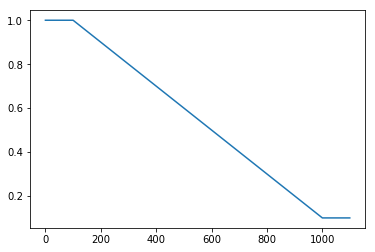

In [6]:
# TESTING the epsilon schedule
%matplotlib inline
import matplotlib.pyplot as plt

schedule    = LinearSchedule(1.0, 0.1, 100, 1000)
test_points = [schedule.value(t) for t in range(1100)]

plt.plot(test_points)

### Deep Q-Network

The original DQN agent included a CNN as shown in the theory part of this notebook. For our task however, a simple MLP with only one hidden layer should be enough. Starting that simple will help you to get other implementation details right. Later on you can easily scale up and switch the MLP for a more powerfull network.

While the architecture will be easy, the DQN algorithm requires us to keep basically two separate networks, namely, a main **Q-Network** and a second **Target-Network**. In addition, Tensorflow requires us to keep a reference to every node we want to calculate with the `sess.run` command. For those reasons we will build a *generic* and reusable `DQNetwork` class and bind all graph nodes to the object. Later we can then simply use the instance objects to reference specifc nodes in a clean and readable way.

We will implement the `DQNetwork` class below in two steps. The first part denoted as *basic Deep Q-Network*, includes the actual network. The second part denote as *Q-Learning Calculations*, includes all the additional calculations to train the network.

#### Part 1 - Basic Deep Q-Network

This part is identical for the main Q- and the Target-Network. **It includes all trainable variables of the graph!** The model should be a fully connected feedforward network with one hidden layer of size $64$ and **ReLU** activations. For the CartPole task, the resulting MLP will consequently be later of size `num_inputs=4, num_hidden=64, num_outputs=2`. For the generic `DQNetwork` class however, let the user specify those values as parameters.

- Now create a `self.best_action` node which should take the output layer (or q-values) and **return the indice** of the maximum action value. You can use `tf.argmax` for that. You can query this node in the e-greedy action selection later.

- Create another node, `self.max_q` which does the same thing but **returns the value** of the maximum action value. You can use `tf.reduce_max` for that. You will need this node for the calculation of the TD-target later.

So far, everything should have been very straightforward.

#### Part 2 - Q-Learning Calculations

This part is different for the Q- and the Target-Network. **It includes all the necessary calculations for training the network.** The code skeleton below shows how to constrain the graph creation with two simple if statements. 

First, the **Target Stream**. This part will later calculate the **TD-Target** (or $y_i$) with the following equation:

$$\begin{eqnarray} 
y_i = r_{t+1} + \gamma \max_a \underbrace{Q(s_{t+1}, a; \theta^{-}_{i})}_{Target-Network}
\end{eqnarray}$$

Remember that we will train with mini-batches sampled from the replay buffer. For that reason, the `reward` values will be provided by mini-batches. This means we have to feed them externally, so let's create a **placeholder node** for those. Next, gamma will be **a constant** so let's create one in tensorflow and let the user specify it as a parameter at creation time of the network. Next, $s_{t+1}$ are the `next_states` from the buffer. This is not important here but you have to feed them correctly later! To get the maximum action value, use the `self.max_q` node that you have created earlier. Finally, there is a small detail we have not talked about yet. **In the rare case that the next state is a final state, i.e the game is over, only the reward should be taken into account.** To realize this here is a little *trick*: create another placeholder for the boolean `done` values from the mini-batch. Then, multiply the right-hand side of the equation with `tf.abs(self.done - 1)`. For clarity call the final node which implements the equation above `self.td_target`! 

> Note that this is a *lot* of text but basically 4 lines of code!

Second, the **Q Stream**. This part will calculate the full **TD-Error** and optimize the mean squared error on the mini-batch.

$$\begin{eqnarray} 
L_i(\theta_{i}) = \mathbb{E}_{(s,a,r,s') \sim U(\mathcal{D})} \Bigg[ \Bigg( y_i - \underbrace{Q(s_t, a_t;\theta_i)}_{Q-Network} \Big)^2 \Bigg]
\end{eqnarray}$$

Now first, create a placeholder for the **td-target** ($y_i$). These values have been calculated by the Target-Network and we must feed them again to the main Q-Network. Yes, its really two **separate** networks even though they share some code here. Next we need the value of $Q(s_t, a_t;\theta_i)$. We can query **all action values** by feeding the mini-batch of `states` ($s_t$) from the buffer to the network (first part of the network). The *problem* is that **we only want to select the action value of the action that was actually taken**. Luckily we have this information as part of the mini-batch. We can feed it with an additional placeholder, let's call it `self.actions`. The idea is now to mask the output of the network with a one-hot encoded representation of the action indices from the placeholder. To do this use `tf.one_hot` and call the resulting node `self.actions_onehot` or similar. Finally multiply the one_hot vector with the output of the network and call `tf.reduce_sum` on the result to obtain a clean list of the action values we want. The resulting node, let's call it `self.Q` holds the values of $Q(s_t, a_t;\theta_i)$ for the complete mini-batch.

> If you feel uncomfortable with this *trick* create a toy example in a separate cell in order to understand whats going on here.

Great, now the rest should be straightforward again. Square the difference of `td_target` and `Q` to obtain the **TD-error** and use `tf.reduce_mean` on that to obtain the expected **loss** of the mini-batch. This corresponds to $\mathbb{E}_{(s,a,r,s') \sim U(\mathcal{D})}$ in the formula. Create an optimizer node such as the AdamOptimizer and again, let the user specifiy the learnin rate as a parameter at creation time of the network. Finally minimize the loss and call this final node something like `self.updateModel` or `self.train`.

> Note that this is again a *lot* of text but *only* something like ~8 lines of code!

In [149]:
import tensorflow as tf

import tensorflow as tf

class DQNetwork():
    
    def __init__(self, scope, num_inputs, num_hidden, num_outputs, gamma, learning_rate):

        self.scope = scope
        
        with tf.variable_scope(self.scope):
            
            # ---------------------
            # Basic Deep Q-Network
            # ---------------------
            # You code comes here     
            self.state = tf.placeholder(tf.float32, shape=[None,num_inputs], name="StatePlaceholder")
                 
            self.hidden = tf.layers.dense(inputs=self.state, units=num_hidden, activation=tf.nn.relu, name="hiddenLayer")
                 
            self.logits = tf.layers.dense(inputs=self.hidden, units=num_outputs, name="logits")
            
            self.best_action = tf.argmax(self.logits, name="best_action", axis=1)
            
            self.max_q = tf.reduce_max(self.logits)
                 
             
            
            # ------------------------
            # Q-Learning Calculations
            # ------------------------
               
            if scope == 'Target':
                # You code comes here  
                self.reward_placeholder = tf.placeholder(tf.float32, shape=None, name="RewardPlaceholder")
                
                self.gamma = tf.constant(value=gamma, name="GammaConstant")
                
                self.done_placeholder = tf.placeholder(tf.int32, shape = None, name="DonePlaceholder")
                
                self.td_target = self.reward_placeholder + ((gamma*self.max_q)*tf.cast(tf.abs(self.done_placeholder - 1), tf.float32))
                
                
              
                
            if scope == 'Q':
                # You code comes here
                self.td_target_placeholder = tf.placeholder(tf.float32, shape=None, name="TD-TargetPlaceholder")
                
                self.actions = tf.placeholder(tf.uint8, shape=None, name="ActionTakenPlaceholder")
                
                self.actions_onehot = tf.one_hot(self.actions, depth=num_outputs)
                
                self.masked_logits = tf.multiply(self.actions_onehot, self.logits)
                
                self.Q = tf.reduce_sum (self.masked_logits)
                
                self.td_error = self.td_target_placeholder - self.Q
                
                self.expected_loss = tf.reduce_mean(self.td_error**2)
                
                self.optimizer = tf.train.AdamOptimizer(learning_rate, name="AdamOptimizer")
                
                self.update_model = self.optimizer.minimize(self.expected_loss, name="minimize_loss")
                
    

In [150]:
# A cell for testing



### E-Greedy Policy

As in the Q-Learning notebook, let us encapsulate the action selection into a separate method. This time however, selecting a greedy max action requires us to perform a forward pass through the Q-Network. The method per se remains as simple as in the Q-Learning case. In order to perform the forward pass of the network though, we have to hand over a reference to the current Tensorflow session object from the main loop etc.

Note that the `sess.run` call will most certainly return a list, containing a single action indice. Make sure to *unpack* it properly before returning it. You can test this in separate cell or in the main loop by using a **fixed epsilon value**.

In [163]:
import numpy as np


def choose_egreedy_action(session, current_state, network, epsilon):
    probability = [epsilon, 1-epsilon]
    
    print("Probability: ", probability)
    
    random_method = [0,1]
    
    action_choice = np.random.choice(random_method, p=probability)
    
    if action_choice == 0:
        # Choose a random Action out of two possibilities (Action 0 and Action 1)
        action = np.random.choice(2)
        
    else:
        current_state = np.reshape(current_state, [1, observation_space])
        action, max_q, logits = session.run([network.best_action, network.max_q, network.logits], feed_dict={network.state:current_state})
        print("Max_q: ",max_q)
        print("Logits: ",logits)
        action = action[0]
    print(action_choice, " : ",action)    
    return action
    

### Update the Target Network

As explained in the theory part, the Target-Network will be fixed for some time $C$ while the main Q-Network gets update every training/update step. Every $C$ time steps however we want to *switch* the networks or better, update the Target-Network with the latest information from the Q-Network. This basically means that we want to copy over all weights from the Q-Network and assign them to the Target-Network. The Q-Network itself remains unchanged. We will control this freeze frequency later inside the main loop and execute the copy process only every $C$ time steps.

Assigning new values to variables in Tensorflow can be done with the `tf.assign` method. But, as everything in TensorFlow, these assign operations will be tensor nodes and **we have to create them before we start the session**. Since they don't belong to any of the networks let us do this in an extra method.

> Note that in (before) the main loop you will have to create both networks first and then hand them to the `get_update_target_ops` method to obtain the list of assign operations!

- get all trainable variables of a network with `tf.trainable_variables(scope=)`.
- better sort the lists using `sorted` and the `attrgetter` helper, e.g `Q_vars = sorted(Q_vars, key=attrgetter('name'))`.
- create an empty list for the assign expressions, let's call them something like `update_target_expr`.
- loop over the variable lists and create assign opertations, e.g. `t_var.assign(q_var)`. Append them to the expression list.
- a handy way for iterating over two lists is zip in a for loop. See the cell below for a little demo.
- return the list of assign operations. You can later simply call `sess.run(update_target_expr)` to run all of the assign operations.


Use the cells below to test your implementation with some toy networks!

In [164]:
# Zip demo
x = [1,2,3]
y = [4,5,6]

for x,y in zip(x,y):
    print(x,y)

1 4
2 5
3 6


In [165]:
from operator import attrgetter

def get_update_target_ops(Q_network, Target_network):

    # You code comes here     
    # 1. get the trainable variables per network
    q_train_vars = tf.trainable_variables(scope=Q_network.scope)
    target_train_vars = tf.trainable_variables(scope=Target_network.scope)
    
    # 2. sort them with sorted(list, key=attrgetter())
    q_train_vars = sorted(q_train_vars, key=attrgetter("name"))
    target_train_vars = sorted(target_train_vars, key=attrgetter("name"))
    
    #print(q_train_vars)
    # 3.create a new list with all assign ops
    update_target_expr = []
    
    for q_var, t_var in zip (q_train_vars, target_train_vars):
        assign_task = t_var.assign(q_var)
        update_target_expr.append(assign_task)

    return update_target_expr

In [166]:
# TESTING get_update_target_ops with some toy networks
tf.reset_default_graph()
Q1 = DQNetwork("Q1", 1,2,1, 0.9, 0.1) 
Q2 = DQNetwork("Q2", 1,2,1, 0.9, 0.1)

Q1_vars = tf.trainable_variables(scope="Q1")
Q2_vars = tf.trainable_variables(scope="Q2")
update_target_expr = get_update_target_ops(Q1, Q2)

print("List of created Assign operations"), print(update_target_expr)
print("\n Q1 Variables"), print(Q1_vars)
print("\n Q2 Variables"), print(Q2_vars)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())        

    print("\n Q1 Values"), print(sess.run(Q1_vars))
    print("\n Q2 Values"), print(sess.run(Q2_vars))
    
    sess.run(update_target_expr)

    print("\n Q2 Values AFTER network copy. Should now be identical to the values of Q1")
    print(sess.run(Q2_vars))  

List of created Assign operations
[<tf.Tensor 'Assign:0' shape=(2,) dtype=float32_ref>, <tf.Tensor 'Assign_1:0' shape=(1, 2) dtype=float32_ref>, <tf.Tensor 'Assign_2:0' shape=(1,) dtype=float32_ref>, <tf.Tensor 'Assign_3:0' shape=(2, 1) dtype=float32_ref>]

 Q1 Variables
[<tf.Variable 'Q1/hiddenLayer/kernel:0' shape=(1, 2) dtype=float32_ref>, <tf.Variable 'Q1/hiddenLayer/bias:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'Q1/logits/kernel:0' shape=(2, 1) dtype=float32_ref>, <tf.Variable 'Q1/logits/bias:0' shape=(1,) dtype=float32_ref>]

 Q2 Variables
[<tf.Variable 'Q2/hiddenLayer/kernel:0' shape=(1, 2) dtype=float32_ref>, <tf.Variable 'Q2/hiddenLayer/bias:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'Q2/logits/kernel:0' shape=(2, 1) dtype=float32_ref>, <tf.Variable 'Q2/logits/bias:0' shape=(1,) dtype=float32_ref>]

 Q1 Values
[array([[0.8270143, 1.2041401]], dtype=float32), array([0., 0.], dtype=float32), array([[-0.13235903],
       [-0.77503264]], dtype=float32), array([0.], dtype

### Train Method

Finally let's create a method to run the actual network training. Doing this in an extra method is not necessary per se but un-clutters the main loop a lot. The implementation requires the following three steps:

1. Sample a mini-batch of experience from the replay buffer. In order to feed everything to the DQNetworks, the mixed batch must be reshaped into separate **list** batches (`[]`!) of `observations, actions, rewards, next_observations` and `done`. Make sure this true before creating corresponding feed_dicts! Depending on your replay buffer implementation you way find it handy to use `zip` again and apply the `list` operator with the `map` function, e.g. `map(list, zip(*batch))`. See the cell below for an UnZip demo.
2. Prepare an appropriate `feed_dict` and get the `td_target` values by running the Target-Network.
3. Prepare an appropriate `feed_dict` and run the `update_model` or `train` operation of the main Q-Network.

Now we can simply call `train` inside the main loop every time we want to train the Q-Network.

In [167]:
# UnZip demo *
mini_batch = [[1,2,3], [1,2,3], [1,2,3]]
    
for i in zip(*mini_batch):
    print(i)

(1, 1, 1)
(2, 2, 2)
(3, 3, 3)


In [168]:
def train(sess, Q, Target, buffer, batch_size):

    # You code comes here     
    # 1. Sample from the replay buffer
    sample = buffer.sample(batch_size)
    
    separate_lists = list(map(list, zip(*sample)))

    observations = separate_lists[0]
    actions = separate_lists[1]
    rewards = separate_lists[2]
    next_observations = separate_lists[3]
    done = separate_lists[4]
    
    
    # 2. Retrieve the TD-target values from the Target-Network
    #inputs = []
    #for obs, act, rew, nex in zip(observations, actions, rewards, next_observations):
    #    inputs.append([obs, act, rew, nex])
    
    for i in range(batch_size):
        
        
        next_observations[i] = np.reshape(next_observations[i], [1, observation_space])
        td_target_feed = {Target.state:next_observations[i], Target.reward_placeholder:rewards[i], Target.done_placeholder:done[i]}

        td_target = sess.run(Target.td_target, feed_dict=td_target_feed)

        # 3. Perform a training step by running the main Q-Network

        observations[i] = np.reshape(observations[i], [1, observation_space])
        sess.run(Q.update_model, feed_dict={Q.state:observations[i], Q.td_target_placeholder: td_target, Q.actions:actions[i]})
    
    

### Main Loop

Below you can see the **Deep Q-Learning** pseudo code from the original paper. This will help you to get at least the main parts of the algorithm right and should serve as a rough blue print of when to do what inside the loop. In practice, there are many more subtle details which are not mentioned explicitly. For that reason we provide you an additional checklist below the algorithm so you don't miss anything important. **As in the last notebook we strongly recommend to start simple and work through the steps one by one!** In addition, the checklist provides some sane default ranges for the hyperparameters to get you started. Try different settings and make it work :) **If you have problems, better start with *huge* values and reduce them step by step as needed!**

> Hint: Personally I like to put the (hyperparameters and the preparation stuff) and the actual loop in separate code cells. You don't have to follow this *convention*. If you prefer one huge code cell, that's fine. Just do what works best for you!

---
##### Deep Q-Learning with experience replay

- Initialize replay memory $D$ to capacity $N$
- Initialize action-value function $Q$ with random weights $\theta$
- Initialize target action-value function $\hat{Q}$ with random weights $\theta^{-}$

- **For** $t = 1, T$ **do**
    - With probability $\epsilon$ select a random action $a_t$
    - otherwise select $a_t = \text{arg}\max_a Q(s_t,a;\theta)$
    <br><br>
    - Execute action $a_t$ in emulator and observe reward $r_t$ and state $s_{t+1}$
    - Store transition $(s_t,a_t,r_t,s_{t+1})$ in $D$
    - Sample random minibatch transitions $(s_j,a_j,r_j,s_{j+1})$ from $D$
    - set    
    $
    y_j = \begin{cases}
          r_j  & \text{if episode terminates at step } j + 1 \\               
          r_j + \gamma \max_a \hat{Q}(s_{j+1}, a; \theta^{-})  & \text{otherwise}
        \end{cases}
$
    
    - Perform a gradient descent step on $\big(y_j - Q(s_j,a_j;\theta)\big)^2$ with respect to the network parameters $\theta$
    - Every $C$ steps reset $\hat{Q} = Q$
- **End For**
---
#####  Deep Q-Learning - PIA checklist 

> This is a helpful checklist without any claim to completeness. Depending on your implementation you may add, change or remove parameters as you like!

**Preparation and hyper parameters**

- Epsilon Schedule
    - `start_epsilon` $1$
    - `final_epsilon` $\in \{0.02,0.1\}$ 
    - `pre_training_steps` $\sim[32,...,10000]$
    - `final_exploration_step` $\sim [100,...,40000]$

- Replay Buffer
    - `buffer_size` $N \in \{32,100,500,1000,10000,50000, ...?\}$ (Bigger is better but try small ones too!)

- Training
    - total/max time steps `T` $\in \{10k,20k,30k,40k,100k\}$
    - `training_freq` $1$ - train the Q-Network only every $n$ steps. For now just use 1 as default.
    - `switch_networks` $C \sim 500$ 
    - `gamma` $\in \{0.9, 0.99, 1\}$
    - `batch_size` $32$
    - `learning_rate` $0.001$
    
- Model
    - always call `tf.reset_default_graph()` before creating a new graph
    - get the `observation_space` and `action_space` from the game env
    - `num_hidden` $64$
    - create a `Q_network` and `T_network` with scope `"Q"` and `"Target"`
    - save the result from `get_update_target_ops` to something like `update_target_network`
    
**Inside the Loop**

- Use the pseudo code as a guideline
- Remember to train and switch the networks only after `t` becomes `t > pre_training_steps`
- Maybe obvious but remember to set `observation = new_observation` for $t+1$

**If the Loop runs without errors**

- Create insight
    - keep track of the episode rewards, calculate a 10 mean, 100 mean
    - print some info every $n'th \sim 2000$ time step, e.g. current step, epsilon, mean reward etc.
    - plot the epsilon schedule vs. the reward
   
- Save/Load the model - needed for the test evaluation later
    - `saver = tf.train.Saver()` - outside the session
    - `saver.save(sess, "./some_path/model.ckpt")` - with an active session
    - `saver.restore(sess, "./some_path/model.ckpt")` - with a new session. In this case `tf.global_variables_initializer()` is not required. A fitting graph definition however is. If there is none left in ram, e.g. if the kernel was restartet, make sure you recreate the graph definition before restoring (at least the main Q-Network). You will need it anyway to reference nodes in the `sess.run` calls later. 

In [169]:
import gym
import tensorflow as tf

# Create a new game
game = gym.make('CartPole-v0')

In [170]:
# Your code comes here
tf.reset_default_graph()

# Hyperparameters:
## Epsilon Schedule
start_epsilon = 1 
final_epsilon = 0.02 
pre_training_steps = 200
final_exploration_step = 20000
epsilon_schedule = LinearSchedule(start_epsilon, final_epsilon, pre_training_steps, final_exploration_step)

## Replay Buffer
buffer_size = 5000

## Training
### Max Trainsteps T
T = 50000
### Currently use 1 as Train Frequency 1 = 100% of steps are being trained
train_freq = 1
### Update the Target Network every 500 steps
switch_networks = 500
### Set Gamma
gamma = 0.95
### Set Batch Size
batch_size = 32
### Set Learning Rate
learn_rate = 0.001

##Model
hidden_layers = 64

In [171]:
#Preparation
replay = ReplayBuffer(buffer_size)
Q_network = DQNetwork("Q",
                      game.observation_space.shape[0],
                      hidden_layers,
                      game.action_space.n,
                      gamma,
                      learn_rate)

Target_network = DQNetwork("Target",
                           game.observation_space.shape[0],
                           hidden_layers,
                           game.action_space.n,
                           gamma,
                           learn_rate)

update_target_network = get_update_target_ops(Q_network,Target_network)

In [172]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    state = game.reset()
    state = np.reshape(state, [1, game.observation_space.shape[0]])
    
    episode = 0
    # Your code comes here
    for t in range(T):
        episode+=1
        current_epsilon = epsilon_schedule.value(t)
        print("current epsilon: ",current_epsilon)
        
        action = choose_egreedy_action(session=sess, current_state=state, network=Q_network, epsilon=current_epsilon)
        
        print("action: ", action)

        state_next, reward, terminal, info = game.step(action)
        print(episode, "-", t, state_next, reward, terminal, info)
        replay.add(state, action, reward, state_next, terminal)
        
        if terminal:
            print("End of Game")
            state = game.reset()
            state = np.reshape(state, [1, game.observation_space.shape[0]])
            episode = 0

        else:
            if t > pre_training_steps:
                # Train and Update Target Network Variables
                print("Training")
                train(sess,Q_network,Target_network,replay,batch_size)

                if(t%switch_networks==0):
                    print("update Target network")
                    sess.run(update_target_network)

        state = state_next


current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
1 - 0 [ 0.04309871 -0.20997532  0.02234603  0.27556504] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
2 - 1 [ 0.03889921 -0.40540885  0.02785733  0.57521132] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  1
action:  1
3 - 2 [ 0.03079103 -0.21068827  0.03936156  0.29143277] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
4 - 3 [ 0.02657727 -0.40634871  0.04519021  0.59626542] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
5 - 4 [ 0.01845029 -0.60207297  0.05711552  0.9028335 ] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
6 - 5 [ 0.00640883 -0.79792017  0.07517219  1.21290809] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
7 - 6 [-0.00954957 -0.99392746  0.09943035  1.52816853] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
8 - 7 [-0.02942812 -1.19009841  0.129

0  :  1
action:  1
12 - 111 [ 0.01949588  0.34118408  0.06699221 -0.35966508] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
13 - 112 [ 0.02631956  0.14517695  0.05979891 -0.04663292] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
14 - 113 [ 0.0292231  -0.05074923  0.05886625  0.26430146] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
15 - 114 [ 0.02820812 -0.24665984  0.06415228  0.57495504] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  1
action:  1
16 - 115 [ 0.02327492 -0.05249312  0.07565138  0.30315191] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
17 - 116 [ 0.02222506 -0.24860714  0.08171442  0.61870185] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
18 - 117 [ 0.01725291 -0.44476967  0.09408846  0.93596115] 1.0 False {}
current epsilon:  1
Probability:  [1, 0]
0  :  0
action:  0
19 - 118 [ 0.00835752 -0.641026    0.11280768  1.25666476

current epsilon:  0.9999010101010101
Probability:  [0.9999010101010101, 9.898989898993182e-05]
0  :  1
action:  1
14 - 202 [ 0.04471296  0.35785432  0.05122295 -0.33973339] 1.0 False {}
Training
current epsilon:  0.9998515151515152
Probability:  [0.9998515151515152, 0.00014848484848484222]
0  :  0
action:  0
15 - 203 [ 0.05187005  0.16204237  0.04442828 -0.03134774] 1.0 False {}
Training
current epsilon:  0.9998020202020202
Probability:  [0.9998020202020202, 0.00019797979797975263]
0  :  0
action:  0
16 - 204 [ 0.05511089 -0.03368762  0.04380133  0.27501514] 1.0 False {}
Training
current epsilon:  0.9997525252525252
Probability:  [0.9997525252525252, 0.00024747474747477405]
0  :  0
action:  0
17 - 205 [ 0.05443714 -0.22940625  0.04930163  0.58118499] 1.0 False {}
Training
current epsilon:  0.9997030303030303
Probability:  [0.9997030303030303, 0.00029696969696968445]
0  :  0
action:  0
18 - 206 [ 0.04984902 -0.42518308  0.06092533  0.88898222] 1.0 False {}
Training
current epsilon:  0.9

current epsilon:  0.9977232323232323
Probability:  [0.9977232323232323, 0.002276767676767655]
0  :  0
action:  0
58 - 246 [ 0.3906699   0.36406569 -0.13032501 -0.48012866] 1.0 False {}
Training
current epsilon:  0.9976737373737373
Probability:  [0.9976737373737373, 0.002326262626262676]
0  :  1
action:  1
59 - 247 [ 0.39795121  0.5607633  -0.13992758 -0.81088018] 1.0 False {}
Training
current epsilon:  0.9976242424242424
Probability:  [0.9976242424242424, 0.0023757575757575866]
0  :  1
action:  1
60 - 248 [ 0.40916648  0.75749644 -0.15614518 -1.14410021] 1.0 False {}
Training
current epsilon:  0.9975747474747475
Probability:  [0.9975747474747475, 0.002425252525252497]
0  :  0
action:  0
61 - 249 [ 0.42431641  0.56472015 -0.17902719 -0.90417409] 1.0 False {}
Training
current epsilon:  0.9975252525252525
Probability:  [0.9975252525252525, 0.0024747474747475184]
0  :  1
action:  1
62 - 250 [ 0.43561081  0.76175591 -0.19711067 -1.24735729] 1.0 False {}
Training
current epsilon:  0.99747575

current epsilon:  0.9955949494949495
Probability:  [0.9955949494949495, 0.004405050505050467]
0  :  1
action:  1
3 - 289 [-0.04588965  0.16237437  0.04429182 -0.22599242] 1.0 False {}
Training
current epsilon:  0.9955454545454545
Probability:  [0.9955454545454545, 0.004454545454545489]
0  :  0
action:  0
4 - 290 [-0.04264216 -0.03335168  0.03977197  0.08032626] 1.0 False {}
Training
current epsilon:  0.9954959595959596
Probability:  [0.9954959595959596, 0.004504040404040399]
0  :  1
action:  1
5 - 291 [-0.0433092   0.16117823  0.0413785  -0.19954798] 1.0 False {}
Training
current epsilon:  0.9954464646464647
Probability:  [0.9954464646464647, 0.00455353535353531]
0  :  0
action:  0
6 - 292 [-0.04008563 -0.03451036  0.03738754  0.10589546] 1.0 False {}
Training
current epsilon:  0.9953969696969697
Probability:  [0.9953969696969697, 0.004603030303030331]
0  :  1
action:  1
7 - 293 [-0.04077584  0.16005641  0.03950545 -0.17476137] 1.0 False {}
Training
current epsilon:  0.9953474747474748

current epsilon:  0.9933676767676768
Probability:  [0.9933676767676768, 0.006632323232323212]
0  :  0
action:  0
18 - 334 [ 0.04401794 -0.42464771  0.03144119  0.66714896] 1.0 False {}
Training
current epsilon:  0.9933181818181818
Probability:  [0.9933181818181818, 0.006681818181818233]
0  :  0
action:  0
19 - 335 [ 0.03552499 -0.62019248  0.04478417  0.96956334] 1.0 False {}
Training
current epsilon:  0.9932686868686869
Probability:  [0.9932686868686869, 0.006731313131313144]
0  :  0
action:  0
20 - 336 [ 0.02312114 -0.81588609  0.06417543  1.27597158] 1.0 False {}
Training
current epsilon:  0.993219191919192
Probability:  [0.993219191919192, 0.006780808080808054]
0  :  1
action:  1
21 - 337 [ 0.00680342 -0.62163857  0.08969487  1.00405473] 1.0 False {}
Training
current epsilon:  0.9931696969696969
Probability:  [0.9931696969696969, 0.006830303030303075]
0  :  0
action:  0
22 - 338 [-0.00562935 -0.8178367   0.10977596  1.32350383] 1.0 False {}
Training
current epsilon:  0.993120202020

current epsilon:  0.991189898989899
Probability:  [0.991189898989899, 0.008810101010101046]
0  :  0
action:  0
9 - 378 [ 0.10753389  0.56997923 -0.11753385 -0.99918179] 1.0 False {}
Training
current epsilon:  0.991140404040404
Probability:  [0.991140404040404, 0.008859595959595956]
0  :  1
action:  1
10 - 379 [ 0.11893347  0.7664594  -0.13751749 -1.32634418] 1.0 False {}
Training
current epsilon:  0.9910909090909091
Probability:  [0.9910909090909091, 0.008909090909090867]
0  :  1
action:  1
11 - 380 [ 0.13426266  0.96302323 -0.16404437 -1.65870922] 1.0 False {}
Training
current epsilon:  0.9910414141414141
Probability:  [0.9910414141414141, 0.008958585858585888]
0  :  0
action:  0
12 - 381 [ 0.15352312  0.77014996 -0.19721856 -1.42129637] 1.0 False {}
Training
current epsilon:  0.9909919191919192
Probability:  [0.9909919191919192, 0.009008080808080798]
0  :  0
action:  0
13 - 382 [ 0.16892612  0.57793745 -0.22564448 -1.19617367] 1.0 True {}
End of Game
current epsilon:  0.9909424242424

current epsilon:  0.9890121212121212
Probability:  [0.9890121212121212, 0.010987878787878769]
0  :  1
action:  1
5 - 422 [ 0.01816242  0.14324343  0.0621466  -0.24927662] 1.0 False {}
Training
current epsilon:  0.9889626262626262
Probability:  [0.9889626262626262, 0.01103737373737379]
0  :  1
action:  1
6 - 423 [ 0.02102729  0.33742536  0.05716106 -0.52172788] 1.0 False {}
Training
current epsilon:  0.9889131313131313
Probability:  [0.9889131313131313, 0.0110868686868687]
0  :  0
action:  0
7 - 424 [ 0.0277758   0.14154737  0.04672651 -0.21159457] 1.0 False {}
Training
current epsilon:  0.9888636363636364
Probability:  [0.9888636363636364, 0.011136363636363611]
0  :  0
action:  0
8 - 425 [ 0.03060674 -0.05421044  0.04249461  0.09545424] 1.0 False {}
Training
current epsilon:  0.9888141414141414
Probability:  [0.9888141414141414, 0.011185858585858632]
0  :  0
action:  0
9 - 426 [ 0.02952253 -0.24991487  0.0444037   0.40123554] 1.0 False {}
Training
current epsilon:  0.9887646464646465
P

current epsilon:  0.9868838383838384
Probability:  [0.9868838383838384, 0.013116161616161581]
0  :  0
action:  0
5 - 465 [ 2.80256479e-02 -5.56614630e-01 -6.15324909e-04  8.82439106e-01] 1.0 False {}
Training
current epsilon:  0.9868343434343434
Probability:  [0.9868343434343434, 0.013165656565656603]
0  :  1
action:  1
6 - 466 [ 0.01689336 -0.36148433  0.01703346  0.5895628 ] 1.0 False {}
Training
current epsilon:  0.9867848484848485
Probability:  [0.9867848484848485, 0.013215151515151513]
0  :  0
action:  0
7 - 467 [ 0.00966367 -0.55684059  0.02882471  0.88756228] 1.0 False {}
Training
current epsilon:  0.9867353535353536
Probability:  [0.9867353535353536, 0.013264646464646423]
0  :  1
action:  1
8 - 468 [-0.00147314 -0.36212149  0.04657596  0.60407825] 1.0 False {}
Training
current epsilon:  0.9866858585858586
Probability:  [0.9866858585858586, 0.013314141414141445]
0  :  0
action:  0
9 - 469 [-0.00871557 -0.55786282  0.05865752  0.91106021] 1.0 False {}
Training
current epsilon:  0

current epsilon:  0.9847555555555556
Probability:  [0.9847555555555556, 0.015244444444444394]
0  :  0
action:  0
4 - 508 [ 0.03724548 -0.04293364  0.0157297   0.03144998] 1.0 False {}
Training
current epsilon:  0.9847060606060606
Probability:  [0.9847060606060606, 0.015293939393939415]
0  :  0
action:  0
5 - 509 [ 0.03638681 -0.23827759  0.0163587   0.32905399] 1.0 False {}
Training
current epsilon:  0.9846565656565657
Probability:  [0.9846565656565657, 0.015343434343434326]
0  :  0
action:  0
6 - 510 [ 0.03162126 -0.43362855  0.02293978  0.62685048] 1.0 False {}
Training
current epsilon:  0.9846070707070707
Probability:  [0.9846070707070707, 0.015392929292929347]
0  :  1
action:  1
7 - 511 [ 0.02294869 -0.23883418  0.03547679  0.3414795 ] 1.0 False {}
Training
current epsilon:  0.9845575757575757
Probability:  [0.9845575757575757, 0.015442424242424257]
0  :  1
action:  1
8 - 512 [ 0.018172   -0.04423447  0.04230638  0.0601916 ] 1.0 False {}
Training
current epsilon:  0.984508080808080

current epsilon:  0.9825282828282829
Probability:  [0.9825282828282829, 0.017471717171717138]
0  :  1
action:  1
3 - 553 [ 0.04322931  0.2345162   0.00380834 -0.31205392] 1.0 False {}
Training
current epsilon:  0.9824787878787878
Probability:  [0.9824787878787878, 0.01752121212121216]
0  :  1
action:  1
4 - 554 [ 0.04791963  0.42958369 -0.00243274 -0.60353338] 1.0 False {}
Training
current epsilon:  0.9824292929292929
Probability:  [0.9824292929292929, 0.01757070707070707]
0  :  0
action:  0
5 - 555 [ 0.05651131  0.23449585 -0.01450341 -0.31161771] 1.0 False {}
Training
current epsilon:  0.982379797979798
Probability:  [0.982379797979798, 0.01762020202020198]
0  :  1
action:  1
6 - 556 [ 0.06120122  0.42982139 -0.02073576 -0.60883906] 1.0 False {}
Training
current epsilon:  0.982330303030303
Probability:  [0.982330303030303, 0.017669696969697002]
0  :  0
action:  0
7 - 557 [ 0.06979765  0.23499536 -0.03291254 -0.32275873] 1.0 False {}
Training
current epsilon:  0.9822808080808081
Proba

current epsilon:  0.9804
Probability:  [0.9804, 0.01959999999999995]
0  :  1
action:  1
18 - 596 [-0.0682267  -0.01804075  0.21689241  0.55752159] 1.0 True {}
End of Game
current epsilon:  0.980350505050505
Probability:  [0.980350505050505, 0.019649494949494972]
0  :  1
action:  1
1 - 597 [-0.01807453  0.22653262  0.0149317  -0.25563735] 1.0 False {}
Training
current epsilon:  0.9803010101010101
Probability:  [0.9803010101010101, 0.019698989898989883]
0  :  0
action:  0
2 - 598 [-0.01354388  0.03120069  0.00981895  0.04171763] 1.0 False {}
Training
current epsilon:  0.9802515151515152
Probability:  [0.9802515151515152, 0.019748484848484793]
0  :  0
action:  0
3 - 599 [-0.01291986 -0.16406067  0.0106533   0.33748228] 1.0 False {}
Training
current epsilon:  0.9802020202020202
Probability:  [0.9802020202020202, 0.019797979797979814]
0  :  1
action:  1
4 - 600 [-0.01620108  0.03090807  0.01740295  0.04817778] 1.0 False {}
Training
current epsilon:  0.9801525252525253
Probability:  [0.98015

current epsilon:  0.9782717171717171
Probability:  [0.9782717171717171, 0.021728282828282874]
0  :  0
action:  0
15 - 639 [-0.04035104 -0.20858605  0.16336844  0.66443326] 1.0 False {}
Training
current epsilon:  0.9782222222222222
Probability:  [0.9782222222222222, 0.021777777777777785]
0  :  0
action:  0
16 - 640 [-0.04452276 -0.40555818  0.1766571   1.00377439] 1.0 False {}
Training
current epsilon:  0.9781727272727273
Probability:  [0.9781727272727273, 0.021827272727272695]
0  :  0
action:  0
17 - 641 [-0.05263392 -0.60254336  0.19673259  1.34632102] 1.0 False {}
Training
current epsilon:  0.9781232323232323
Probability:  [0.9781232323232323, 0.021876767676767717]
0  :  0
action:  0
18 - 642 [-0.06468479 -0.79951818  0.22365901  1.69355093] 1.0 True {}
End of Game
current epsilon:  0.9780737373737374
Probability:  [0.9780737373737374, 0.021926262626262627]
0  :  0
action:  0
1 - 643 [-0.04092388 -0.21752529  0.01392808  0.34610237] 1.0 False {}
Training
current epsilon:  0.978024242

current epsilon:  0.9761929292929293
Probability:  [0.9761929292929293, 0.023807070707070666]
0  :  0
action:  0
27 - 681 [ 0.15648036  0.25278958 -0.20446232 -0.67936046] 1.0 False {}
Training
current epsilon:  0.9761434343434343
Probability:  [0.9761434343434343, 0.023856565656565687]
0  :  0
action:  0
28 - 682 [ 0.16153615  0.06100597 -0.21804953 -0.45737121] 1.0 True {}
End of Game
current epsilon:  0.9760939393939394
Probability:  [0.9760939393939394, 0.023906060606060597]
0  :  1
action:  1
1 - 683 [ 0.0070185   0.1956649   0.02560321 -0.27902856] 1.0 False {}
Training
current epsilon:  0.9760444444444445
Probability:  [0.9760444444444445, 0.023955555555555508]
0  :  0
action:  0
2 - 684 [0.0109318  0.00018724 0.02002264 0.02161835] 1.0 False {}
Training
current epsilon:  0.9759949494949495
Probability:  [0.9759949494949495, 0.02400505050505053]
0  :  1
action:  1
3 - 685 [ 0.01093554  0.1950164   0.02045501 -0.26468056] 1.0 False {}
Training
current epsilon:  0.9759454545454546

action:  1
23 - 723 [ 0.15494386  0.2097931  -0.06946749 -0.27943617] 1.0 False {}
Training
current epsilon:  0.9740646464646465
Probability:  [0.9740646464646465, 0.025935353535353478]
0  :  0
action:  0
24 - 724 [ 0.15913972  0.01572734 -0.07505621 -0.00944665] 1.0 False {}
Training
current epsilon:  0.9740151515151515
Probability:  [0.9740151515151515, 0.0259848484848485]
0  :  0
action:  0
25 - 725 [ 0.15945426 -0.17824243 -0.07524515  0.25864305] 1.0 False {}
Training
current epsilon:  0.9739656565656566
Probability:  [0.9739656565656566, 0.02603434343434341]
0  :  0
action:  0
26 - 726 [ 0.15588942 -0.37221403 -0.07007229  0.52667595] 1.0 False {}
Training
current epsilon:  0.9739161616161616
Probability:  [0.9739161616161616, 0.02608383838383843]
0  :  0
action:  0
27 - 727 [ 0.14844514 -0.56628366 -0.05953877  0.79648162] 1.0 False {}
Training
current epsilon:  0.9738666666666667
Probability:  [0.9738666666666667, 0.026133333333333342]
0  :  0
action:  0
28 - 728 [ 0.13711946 -

current epsilon:  0.9719363636363636
Probability:  [0.9719363636363636, 0.0280636363636364]
0  :  1
action:  1
8 - 767 [ 0.0029715  -0.35597882 -0.03194303  0.45623664] 1.0 False {}
Training
current epsilon:  0.9718868686868687
Probability:  [0.9718868686868687, 0.028113131313131312]
0  :  0
action:  0
9 - 768 [-0.00414808 -0.55063493 -0.0228183   0.7386822 ] 1.0 False {}
Training
current epsilon:  0.9718373737373738
Probability:  [0.9718373737373738, 0.028162626262626222]
0  :  0
action:  0
10 - 769 [-0.01516078 -0.74543447 -0.00804466  1.02409745] 1.0 False {}
Training
current epsilon:  0.9717878787878788
Probability:  [0.9717878787878788, 0.028212121212121244]
0  :  1
action:  1
11 - 770 [-0.03006947 -0.55020631  0.01243729  0.72889958] 1.0 False {}
Training
current epsilon:  0.9717383838383838
Probability:  [0.9717383838383838, 0.028261616161616154]
0  :  1
action:  1
12 - 771 [-0.04107359 -0.35525847  0.02701528  0.4401569 ] 1.0 False {}
Training
current epsilon:  0.97168888888888

current epsilon:  0.9698575757575758
Probability:  [0.9698575757575758, 0.030142424242424193]
0  :  0
action:  0
12 - 809 [ 0.00358337 -0.4320569  -0.02700614  0.51098939] 1.0 False {}
Training
current epsilon:  0.9698080808080808
Probability:  [0.9698080808080808, 0.030191919191919214]
0  :  1
action:  1
13 - 810 [-0.00505777 -0.23656514 -0.01678635  0.20991983] 1.0 False {}
Training
current epsilon:  0.9697585858585859
Probability:  [0.9697585858585859, 0.030241414141414125]
0  :  1
action:  1
14 - 811 [-0.00978907 -0.04120724 -0.01258795 -0.08801068] 1.0 False {}
Training
current epsilon:  0.9697090909090909
Probability:  [0.9697090909090909, 0.030290909090909146]
0  :  1
action:  1
15 - 812 [-0.01061322  0.15409286 -0.01434816 -0.38463839] 1.0 False {}
Training
current epsilon:  0.9696595959595959
Probability:  [0.9696595959595959, 0.030340404040404056]
0  :  0
action:  0
16 - 813 [-0.00753136 -0.04082248 -0.02204093 -0.09651369] 1.0 False {}
Training
current epsilon:  0.9696101010

current epsilon:  0.9677292929292929
Probability:  [0.9677292929292929, 0.032270707070707116]
0  :  1
action:  1
55 - 852 [-0.08733236 -0.66750558  0.23974628  1.73574812] 1.0 True {}
End of Game
current epsilon:  0.967679797979798
Probability:  [0.967679797979798, 0.03232020202020203]
0  :  1
action:  1
1 - 853 [-0.00236313  0.23026722 -0.02531955 -0.26181525] 1.0 False {}
Training
current epsilon:  0.9676303030303031
Probability:  [0.9676303030303031, 0.03236969696969694]
0  :  0
action:  0
2 - 854 [ 0.00224222  0.03551568 -0.03055586  0.02277529] 1.0 False {}
Training
current epsilon:  0.967580808080808
Probability:  [0.967580808080808, 0.03241919191919196]
0  :  0
action:  0
3 - 855 [ 0.00295253 -0.15915505 -0.03010035  0.30566305] 1.0 False {}
Training
current epsilon:  0.9675313131313131
Probability:  [0.9675313131313131, 0.03246868686868687]
0  :  1
action:  1
4 - 856 [-0.00023057  0.03638262 -0.02398709  0.00364124] 1.0 False {}
Training
current epsilon:  0.9674818181818182
Pro

current epsilon:  0.9655515151515152
Probability:  [0.9655515151515152, 0.03444848484848484]
0  :  1
action:  1
28 - 896 [ 0.19901024  1.5745443  -0.23942264 -2.35420318] 1.0 True {}
End of Game
current epsilon:  0.9655020202020203
Probability:  [0.9655020202020203, 0.03449797979797975]
0  :  0
action:  0
1 - 897 [ 0.01493236 -0.1734734   0.02382725  0.27082571] 1.0 False {}
Training
current epsilon:  0.9654525252525252
Probability:  [0.9654525252525252, 0.03454747474747477]
0  :  0
action:  0
2 - 898 [ 0.01146289 -0.36892711  0.02924376  0.57092761] 1.0 False {}
Training
current epsilon:  0.9654030303030303
Probability:  [0.9654030303030303, 0.03459696969696968]
0  :  0
action:  0
3 - 899 [ 0.00408435 -0.56444669  0.04066231  0.87267803] 1.0 False {}
Training
current epsilon:  0.9653535353535354
Probability:  [0.9653535353535354, 0.03464646464646459]
0  :  1
action:  1
4 - 900 [-0.00720458 -0.36990058  0.05811587  0.5930515 ] 1.0 False {}
Training
current epsilon:  0.9653040404040404


current epsilon:  0.9634232323232323
Probability:  [0.9634232323232323, 0.03657676767676765]
0  :  0
action:  0
16 - 939 [-0.05307395 -0.400423    0.20070954  1.12933256] 1.0 False {}
Training
current epsilon:  0.9633737373737373
Probability:  [0.9633737373737373, 0.03662626262626267]
0  :  1
action:  1
17 - 940 [-0.06108241 -0.20841319  0.22329619  0.90571284] 1.0 True {}
End of Game
current epsilon:  0.9633242424242424
Probability:  [0.9633242424242424, 0.036675757575757584]
0  :  1
action:  1
1 - 941 [ 0.01627022  0.15328895 -0.01518199 -0.32351419] 1.0 False {}
Training
current epsilon:  0.9632747474747475
Probability:  [0.9632747474747475, 0.036725252525252494]
0  :  1
action:  1
2 - 942 [ 0.019336    0.34862376 -0.02165227 -0.62094596] 1.0 False {}
Training
current epsilon:  0.9632252525252525
Probability:  [0.9632252525252525, 0.036774747474747516]
0  :  1
action:  1
3 - 943 [ 0.02630847  0.54404129 -0.03407119 -0.92036882] 1.0 False {}
Training
current epsilon:  0.9631757575757

current epsilon:  0.9612949494949495
Probability:  [0.9612949494949495, 0.038705050505050465]
0  :  1
action:  1
24 - 982 [-0.00998956  0.75177554  0.03768745 -0.76901285] 1.0 False {}
Training
current epsilon:  0.9612454545454545
Probability:  [0.9612454545454545, 0.038754545454545486]
0  :  0
action:  0
25 - 983 [ 0.00504595  0.55615567  0.02230719 -0.46471391] 1.0 False {}
Training
current epsilon:  0.9611959595959596
Probability:  [0.9611959595959596, 0.038804040404040396]
0  :  0
action:  0
26 - 984 [ 0.01616906  0.36072572  0.01301292 -0.16508415] 1.0 False {}
Training
current epsilon:  0.9611464646464647
Probability:  [0.9611464646464647, 0.03885353535353531]
0  :  0
action:  0
27 - 985 [0.02338358 0.16541993 0.00971123 0.13167542] 1.0 False {}
Training
current epsilon:  0.9610969696969697
Probability:  [0.9610969696969697, 0.03890303030303033]
0  :  1
action:  1
28 - 986 [ 0.02669198  0.36040143  0.01234474 -0.15792799] 1.0 False {}
Training
current epsilon:  0.9610474747474748

3 - 1026 [ 0.02055677 -0.16499405  0.02771784  0.32305568] 1.0 False {}
Training
current epsilon:  0.9590676767676768
Probability:  [0.9590676767676768, 0.04093232323232321]
0  :  0
action:  0
4 - 1027 [ 0.01725689 -0.3604995   0.03417896  0.62434922] 1.0 False {}
Training
current epsilon:  0.9590181818181818
Probability:  [0.9590181818181818, 0.04098181818181823]
0  :  0
action:  0
5 - 1028 [ 0.0100469  -0.55608154  0.04666594  0.92759759] 1.0 False {}
Training
current epsilon:  0.9589686868686869
Probability:  [0.9589686868686869, 0.04103131313131314]
0  :  0
action:  0
6 - 1029 [-1.07473491e-03 -7.51801453e-01  6.52178925e-02  1.23457266e+00] 1.0 False {}
Training
current epsilon:  0.958919191919192
Probability:  [0.958919191919192, 0.04108080808080805]
0  :  1
action:  1
7 - 1030 [-0.01611076 -0.55757562  0.08990935  0.96301376] 1.0 False {}
Training
current epsilon:  0.9588696969696969
Probability:  [0.9588696969696969, 0.04113030303030307]
0  :  1
action:  1
8 - 1031 [-0.02726228

current epsilon:  0.956939393939394
Probability:  [0.956939393939394, 0.04306060606060602]
0  :  1
action:  1
3 - 1070 [-0.05433194  0.15253369  0.00896806 -0.33407422] 1.0 False {}
Training
current epsilon:  0.956889898989899
Probability:  [0.956889898989899, 0.04311010101010104]
0  :  1
action:  1
4 - 1071 [-0.05128126  0.34752686  0.00228658 -0.62391564] 1.0 False {}
Training
current epsilon:  0.956840404040404
Probability:  [0.956840404040404, 0.04315959595959595]
0  :  1
action:  1
5 - 1072 [-0.04433073  0.54261681 -0.01019173 -0.91587755] 1.0 False {}
Training
current epsilon:  0.9567909090909091
Probability:  [0.9567909090909091, 0.043209090909090864]
0  :  0
action:  0
6 - 1073 [-0.03347839  0.34763416 -0.02850928 -0.62641507] 1.0 False {}
Training
current epsilon:  0.9567414141414141
Probability:  [0.9567414141414141, 0.043258585858585885]
0  :  1
action:  1
7 - 1074 [-0.02652571  0.54314221 -0.04103759 -0.92793858] 1.0 False {}
Training
current epsilon:  0.9566919191919192
Pr

Training
current epsilon:  0.9546626262626262
Probability:  [0.9546626262626262, 0.04533737373737379]
0  :  0
action:  0
2 - 1116 [-0.03521516 -0.37328658 -0.01021381  0.55730903] 1.0 False {}
Training
current epsilon:  0.9546131313131313
Probability:  [0.9546131313131313, 0.0453868686868687]
0  :  1
action:  1
3 - 1117 [-0.0426809  -0.17802274  0.00093237  0.26142574] 1.0 False {}
Training
current epsilon:  0.9545636363636364
Probability:  [0.9545636363636364, 0.04543636363636361]
0  :  1
action:  1
4 - 1118 [-0.04624135  0.01708589  0.00616089 -0.03096296] 1.0 False {}
Training
current epsilon:  0.9545141414141414
Probability:  [0.9545141414141414, 0.04548585858585863]
0  :  1
action:  1
5 - 1119 [-0.04589963  0.21211895  0.00554163 -0.32169571] 1.0 False {}
Training
current epsilon:  0.9544646464646465
Probability:  [0.9544646464646465, 0.04553535353535354]
0  :  1
action:  1
6 - 1120 [-0.04165725  0.40716155 -0.00089229 -0.61262588] 1.0 False {}
Training
current epsilon:  0.9544151

current epsilon:  0.9525343434343434
Probability:  [0.9525343434343434, 0.0474656565656566]
0  :  1
action:  1
14 - 1159 [ 0.02336757  0.37430336 -0.02778335 -0.61137127] 1.0 False {}
Training
current epsilon:  0.9524848484848485
Probability:  [0.9524848484848485, 0.04751515151515151]
0  :  1
action:  1
15 - 1160 [ 0.03085363  0.56980239 -0.04001077 -0.91267389] 1.0 False {}
Training
current epsilon:  0.9524353535353536
Probability:  [0.9524353535353536, 0.04756464646464642]
0  :  0
action:  0
16 - 1161 [ 0.04224968  0.37524391 -0.05826425 -0.63282977] 1.0 False {}
Training
current epsilon:  0.9523858585858586
Probability:  [0.9523858585858586, 0.04761414141414144]
0  :  0
action:  0
17 - 1162 [ 0.04975456  0.18098112 -0.07092085 -0.35905003] 1.0 False {}
Training
current epsilon:  0.9523363636363636
Probability:  [0.9523363636363636, 0.04766363636363635]
0  :  0
action:  0
18 - 1163 [ 0.05337418 -0.01306475 -0.07810185 -0.08954618] 1.0 False {}
Training
current epsilon:  0.95228686868

current epsilon:  0.9504555555555556
Probability:  [0.9504555555555556, 0.04954444444444439]
0  :  0
action:  0
5 - 1201 [-0.03989085 -0.57317464  0.05680218  0.92795639] 1.0 False {}
Training
current epsilon:  0.9504060606060606
Probability:  [0.9504060606060606, 0.04959393939393941]
0  :  1
action:  1
6 - 1202 [-0.05135435 -0.3788637   0.07536131  0.65365091] 1.0 False {}
Training
current epsilon:  0.9503565656565657
Probability:  [0.9503565656565657, 0.04964343434343432]
0  :  0
action:  0
7 - 1203 [-0.05893162 -0.57494964  0.08843433  0.96908025] 1.0 False {}
Training
current epsilon:  0.9503070707070707
Probability:  [0.9503070707070707, 0.049692929292929344]
0  :  0
action:  0
8 - 1204 [-0.07043061 -0.77114037  0.10781593  1.28818216] 1.0 False {}
Training
current epsilon:  0.9502575757575757
Probability:  [0.9502575757575757, 0.049742424242424255]
0  :  0
action:  0
9 - 1205 [-0.08585342 -0.96745606  0.13357957  1.61258235] 1.0 False {}
Training
current epsilon:  0.9502080808080

current epsilon:  0.9483767676767677
Probability:  [0.9483767676767677, 0.05162323232323229]
0  :  0
action:  0
35 - 1243 [ 0.0483354  -0.60171715 -0.16121089  0.21295905] 1.0 False {}
Training
current epsilon:  0.9483272727272727
Probability:  [0.9483272727272727, 0.051672727272727315]
0  :  0
action:  0
36 - 1244 [ 0.03630106 -0.79421116 -0.15695171  0.45076517] 1.0 False {}
Training
current epsilon:  0.9482777777777778
Probability:  [0.9482777777777778, 0.051722222222222225]
0  :  0
action:  0
37 - 1245 [ 0.02041684 -0.98680565 -0.1479364   0.69015138] 1.0 False {}
Training
current epsilon:  0.9482282828282829
Probability:  [0.9482282828282829, 0.051771717171717135]
0  :  1
action:  1
38 - 1246 [ 6.80722412e-04 -7.89974296e-01 -1.34133377e-01  3.54794387e-01] 1.0 False {}
Training
current epsilon:  0.9481787878787878
Probability:  [0.9481787878787878, 0.05182121212121216]
0  :  1
action:  1
39 - 1247 [-0.01511876 -0.59322555 -0.12703749  0.02300512] 1.0 False {}
Training
current eps

current epsilon:  0.9462484848484849
Probability:  [0.9462484848484849, 0.053751515151515106]
0  :  1
action:  1
5 - 1286 [-0.00418483  0.55477119 -0.04884239 -0.87395816] 1.0 False {}
Training
current epsilon:  0.9461989898989899
Probability:  [0.9461989898989899, 0.05380101010101013]
0  :  0
action:  0
6 - 1287 [ 0.00691059  0.36034613 -0.06632155 -0.59702231] 1.0 False {}
Training
current epsilon:  0.946149494949495
Probability:  [0.946149494949495, 0.05385050505050504]
0  :  1
action:  1
7 - 1288 [ 0.01411751  0.55633041 -0.078262   -0.90983668] 1.0 False {}
Training
current epsilon:  0.9461
Probability:  [0.9461, 0.05389999999999995]
0  :  0
action:  0
8 - 1289 [ 0.02524412  0.36234989 -0.09645873 -0.64274208] 1.0 False {}
Training
current epsilon:  0.946050505050505
Probability:  [0.946050505050505, 0.05394949494949497]
0  :  1
action:  1
9 - 1290 [ 0.03249112  0.55867457 -0.10931357 -0.96417509] 1.0 False {}
Training
current epsilon:  0.9460010101010101
Probability:  [0.94600101

0  :  0
action:  0
34 - 1328 [-0.02286159 -0.74645159 -0.12589707  0.27734603] 1.0 False {}
Training
current epsilon:  0.944120202020202
Probability:  [0.944120202020202, 0.05587979797979803]
0  :  0
action:  0
35 - 1329 [-0.03779062 -0.93957363 -0.12035015  0.52782035] 1.0 False {}
Training
current epsilon:  0.9440707070707071
Probability:  [0.9440707070707071, 0.05592929292929294]
0  :  1
action:  1
36 - 1330 [-0.0565821  -0.74298228 -0.10979375  0.19976875] 1.0 False {}
Training
current epsilon:  0.9440212121212121
Probability:  [0.9440212121212121, 0.05597878787878785]
0  :  1
action:  1
37 - 1331 [-0.07144174 -0.54647525 -0.10579837 -0.12543151] 1.0 False {}
Training
current epsilon:  0.9439717171717171
Probability:  [0.9439717171717171, 0.05602828282828287]
0  :  1
action:  1
38 - 1332 [-0.08237125 -0.35000923 -0.108307   -0.44952949] 1.0 False {}
Training
current epsilon:  0.9439222222222222
Probability:  [0.9439222222222222, 0.05607777777777778]
0  :  1
action:  1
39 - 1333 [-0

current epsilon:  0.9420414141414142
Probability:  [0.9420414141414142, 0.05795858585858582]
0  :  0
action:  0
32 - 1371 [-0.20410375 -1.19103611  0.04357512  1.35833225] 1.0 False {}
Training
current epsilon:  0.9419919191919192
Probability:  [0.9419919191919192, 0.05800808080808084]
0  :  0
action:  0
33 - 1372 [-0.22792447 -1.38667663  0.07074177  1.66432148] 1.0 False {}
Training
current epsilon:  0.9419424242424242
Probability:  [0.9419424242424242, 0.05805757575757575]
0  :  1
action:  1
34 - 1373 [-0.25565801 -1.19244582  0.1040282   1.39448472] 1.0 False {}
Training
current epsilon:  0.9418929292929293
Probability:  [0.9418929292929293, 0.05810707070707066]
0  :  0
action:  0
35 - 1374 [-0.27950692 -1.38869711  0.13191789  1.71779939] 1.0 False {}
Training
current epsilon:  0.9418434343434343
Probability:  [0.9418434343434343, 0.058156565656565684]
0  :  1
action:  1
36 - 1375 [-0.30728086 -1.19531133  0.16627388  1.46891255] 1.0 False {}
Training
current epsilon:  0.941793939

current epsilon:  0.9399131313131314
Probability:  [0.9399131313131314, 0.06008686868686863]
0  :  0
action:  0
11 - 1414 [ 0.01608556  0.15795659 -0.11379555 -0.47434502] 1.0 False {}
Training
current epsilon:  0.9398636363636363
Probability:  [0.9398636363636363, 0.060136363636363654]
0  :  0
action:  0
12 - 1415 [ 0.0192447  -0.03538994 -0.12328245 -0.21958474] 1.0 False {}
Training
current epsilon:  0.9398141414141414
Probability:  [0.9398141414141414, 0.060185858585858565]
0  :  1
action:  1
13 - 1416 [ 0.0185369   0.16125883 -0.12767414 -0.54847245] 1.0 False {}
Training
current epsilon:  0.9397646464646465
Probability:  [0.9397646464646465, 0.060235353535353475]
0  :  1
action:  1
14 - 1417 [ 0.02176207  0.35792132 -0.13864359 -0.87849945] 1.0 False {}
Training
current epsilon:  0.9397151515151515
Probability:  [0.9397151515151515, 0.0602848484848485]
0  :  0
action:  0
15 - 1418 [ 0.0289205   0.16492799 -0.15621358 -0.63241805] 1.0 False {}
Training
current epsilon:  0.93966565

current epsilon:  0.9377848484848484
Probability:  [0.9377848484848484, 0.06221515151515156]
0  :  1
action:  1
35 - 1457 [ 0.11575429  0.56278005 -0.00472157 -0.4339619 ] 1.0 False {}
Training
current epsilon:  0.9377353535353535
Probability:  [0.9377353535353535, 0.06226464646464647]
Max_q:  2.9448833
Logits:  [[2.8744662 2.9448833]]
1  :  1
action:  1
36 - 1458 [ 0.12700989  0.75796853 -0.01340081 -0.72812949] 1.0 False {}
Training
current epsilon:  0.9376858585858586
Probability:  [0.9376858585858586, 0.06231414141414138]
0  :  1
action:  1
37 - 1459 [ 0.14216926  0.95327314 -0.0279634  -1.02499984] 1.0 False {}
Training
current epsilon:  0.9376363636363636
Probability:  [0.9376363636363636, 0.0623636363636364]
0  :  0
action:  0
38 - 1460 [ 0.16123472  0.7585345  -0.0484634  -0.74122624] 1.0 False {}
Training
current epsilon:  0.9375868686868687
Probability:  [0.9375868686868687, 0.06241313131313131]
0  :  1
action:  1
39 - 1461 [ 0.17640541  0.95429082 -0.06328792 -1.04875862] 1.

current epsilon:  0.9356565656565656
Probability:  [0.9356565656565656, 0.06434343434343437]
0  :  0
action:  0
29 - 1500 [ 0.06005349 -0.94084264 -0.17074379  0.47737356] 1.0 False {}
Training
update Target network
current epsilon:  0.9356070707070707
Probability:  [0.9356070707070707, 0.06439292929292928]
0  :  0
action:  0
30 - 1501 [ 0.04123663 -1.13319462 -0.16119632  0.71175083] 1.0 False {}
Training
current epsilon:  0.9355575757575758
Probability:  [0.9355575757575758, 0.06444242424242419]
0  :  1
action:  1
31 - 1502 [ 0.01857274 -0.93625126 -0.1469613   0.3729788 ] 1.0 False {}
Training
current epsilon:  0.9355080808080808
Probability:  [0.9355080808080808, 0.06449191919191921]
0  :  0
action:  0
32 - 1503 [-1.52282853e-04 -1.12901322e+00 -1.39501727e-01  6.15953696e-01] 1.0 False {}
Training
current epsilon:  0.9354585858585859
Probability:  [0.9354585858585859, 0.06454141414141412]
0  :  1
action:  1
33 - 1504 [-0.02273255 -0.93224631 -0.12718265  0.28278998] 1.0 False {}
T

KeyboardInterrupt: 

### Plot statistics

In [ ]:
# You code comes here

### Evaluation of Deep Reinforcement Learning Algorithms

In general, the evaluation of deep RL is discussed controversially among researchers since it remains unclear how to benchmark and compare such algorithms properly. Is the return or average return a good performance measure? How big is the impact of hyperparameters vs. general algorithm vs. implementation etc.? See the paper [Deep Reinforcement Learning that Matters](https://arxiv.org/abs/1709.06560) from Henderson et al. 2017 for a nice overview of these problems.

As part of this notebook however, we will evaluate our algorithm as done by the authors of DQN. The testing is very simple. Let the trained agent play the game $30$ times with an e-greedy policy with a fixed $\epsilon = 0.05$ and report the average high score (return).

- Load a pre-trained agent, potentially recreate a Q-Network graph.
- Run the agent for 30 episodes with an `evaluation_epsilon = 0.05`.
- Plot or print the results in a decent way.

In [ ]:
import gym
import tensorflow as tf

game = gym.make('CartPole-v0')
# You code comes here

## Further Ideas

- How fast can you train the agent to a test score > 195? In other words, what is the smallest amount of training steps you need to achieve this goal?
- Can you get a mean 100 score > 199?
- As always, experiment with Hyperparameters/Network sizes etc. **and reason about their effects/importance**!
- Implement and experiment with new/different exploration schemes.
    
- Extend the algorithm to play Atari games.

## Playing Atari with Deep Reinforcement Learning

So far you have implemented a basic DQN agent. For simplicity we have left out some important details which are crucial in order to play video games. If you are eager to do this anyway here are the missing parts.

### Architecture

First of all, switch the simple MLP with the following architecture from the paper. Note that there are no pooling layers in this CNN!

<img src="./RL_pics/DQN_architecture.png" alt="DQN" style="width: 800px;"/>

### Observability and Preprocessing

We have not talked about observability so far. Formally, Atari video games are Partially Observable Markov Decision Processes or POMDPs. This means that the game screen is not a sufficient observation to fully describe the underlying state and that the Markov Assumption does not hold. A simple example to makes this clear. Think about the game Pong. Given only one frame, the agent has no way of telling if the ball is currently moving from left to right or from right to left. For that reason the authors used the last 4 frames of the game as observation. This turns the POMDP into an MDP again. Furthermore they applied some more preprocessing steps to the game screens such as turning them into gray scale, rescaling, and taking the max out of two subsequent frames. Please see [the methods section of the DQN paper](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning/) for more details on that.

> Hint: In order to implement this you have to keep some sort of frame buffer of the last 4 frames etc.!

### Training Details

In order to play faster, the authors trained the network only every $K=4$ time step. In between, the last taken action was repeated. This allows to play more games, e.g. gather more experience in less time since stepping the emulator forward is computationally *cheaper* than training the network. Again see the paper for details.

During training, the authors clipped the reward to the range $R \in \{-1,0,1\}$. Remember to remove this constraint during testing again to get the *real high score*

Another way to improve training stability was to clip the gradients (or better the squared L2 loss) to the range -1,1. In other words, only apply L2 if the error is inside this range and take a linear loss outside. This corresponds to a Huber Loss. Here you can find a TensorFlow implementations of that from the [OpenAI baseline agents](https://github.com/openai/baselines/blob/24fe3d6576dd8f4cdd5f017805be689d6fa6be8c/baselines/common/tf_util.py#L39). Please read the [Wikipedia](https://en.wikipedia.org/wiki/Huber_loss) to see what the function is doing.

The original DQN implementation used a slightly modified version of RMSProp as its optimizer. You dont have to implement this. It is perfectly fine to stay with Adam for instance. However, be aware that the learning rate is a really crucial parameter in this context. If at least for any, this is definetly the first (and probably the most important) hyperparameter for which you want to test different settings!

### Hyper Parameters

See the paper for a list of good default parameters. Due to the lengthy training times you may want to reduce the total amount of time steps the agent will be trained. You also may adjust the exploration accordingly. However, be aware that exploration time is very important. You may want to benchmark a very short training first and then do some rough calculations of how long it will take to train the agent for some $x$ time steps etc. Then plan some experiments. 

# References

<sup>[1]</sup> [Tensorflow - tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers/dense)  
<sup>[2]</sup> [Tensorflow - tf.constant](https://www.tensorflow.org/api_docs/python/tf/constant)  
<sup>[3]</sup> [Simple Reinforcement Learning with Tensorflow Part 7: Action-Selection Strategies for Exploration](https://ai-mrkogao.github.io/reinforcement%20learning/actionselectionstrategy/)  
<sup>[4]</sup> [Tensorflow - tf.argmax](https://www.tensorflow.org/api_docs/python/tf/math/argmax)  

